## Benchmark comparativo: Polars - DuckDB - Pandas - Stream (ijson)

Este notebook compara el rendimiento (tiempo y memoria) de las funciones `top_active_dates`, `top_emojis` y `top_mentioned_users` implementadas con los backends: **Pandas**, **Polars**, **DuckDB** e **ijson**.

A continuación se presenta una breve descripción de cada uno de estos frameworks y su enfoque principal:

- **Pandas**  
  Es una de las bibliotecas más populares en Python para manipulación de datos en forma tabular. Construido sobre `numpy`, Pandas ofrece estructuras de datos eficientes (`DataFrame`, `Series`) y operaciones de alto rendimiento en memoria, ideales para datasets que caben completos en RAM.

- **Polars**  
  Es un motor de procesamiento columnar moderno, escrito en Rust, que se apoya en Apache Arrow para un manejo de memoria eficiente y operaciones vectorizadas. Su enfoque en paralelismo y estructuras columnar lo hace especialmente rápido para agregaciones y transformaciones masivas en memoria.

- **DuckDB**  
  Es un motor de bases de datos analíticas embebido, similar en filosofía a SQLite pero orientado a cargas de trabajo OLAP (analíticas). Permite ejecutar consultas SQL directamente sobre archivos (NDJSON, Parquet, CSV) sin necesidad de cargarlos previamente a un DataFrame, y ofrece un motor de ejecución vectorizado muy optimizado.

- **ijson**  
  Es una biblioteca de lectura de JSON en streaming. A diferencia de Pandas, Polars o DuckDB, no carga el archivo completo a memoria. Permite procesar archivos JSON línea por línea o elemento por elemento, siendo ideal para entornos con restricciones de memoria o para procesar datos muy grandes que no caben en RAM.

La comparación presentada en este notebook se centra en medir el **tiempo total de ejecución** y el **pico de memoria** alcanzado por cada backend al ejecutar las funciones principales, utilizando `memory-profiler` y `cProfile` como herramientas de medición.

A priori, **DuckDB** debería ser el más rápido en tiempo de ejecución, ya que en este benchmark se configura en **modo `database=":memory:"`**, lo que permite que toda la consulta y procesamiento se realicen directamente en memoria. Esto evita latencias de disco y aprovecha el motor de ejecución vectorizado y el optimizador SQL de DuckDB.

Por otro lado, **ijson** debería ser el óptimo en consumo de memoria, ya que no carga todo el archivo NDJSON en un DataFrame o estructura tabular, sino que procesa línea por línea en forma de *streaming*. De este modo, solo mantiene en memoria la línea actual y las estructuras de acumulación necesarias (por ejemplo, contadores), evitando cargar el dataset completo en RAM.

-----

#### Librerías utilizadas en el benchmark

En este benchmark emplearemos tres herramientas para medir tanto el **tiempo de ejecución** como el **consumo de memoria** de cada backen.d A continuación se describen brevemente:

- **cProfile**  
  Es el módulo estándar de Python para realizar perfilado de ejecución de código. Permite registrar cuántas veces se invoca cada función y cuánto tiempo dedica (tanto el tiempo “propio” de la función como el tiempo acumulado incluyendo llamadas internas).

- **pstats**  
  Es un submódulo de Python que trabaja junto a `cProfile`. Permite cargar y organizar la información cruda generada por dicha librería.

- **memory-profiler**  
  Es una biblioteca externa que mide el uso de memoria de un fragmento de código Python en intervalos regulares. La función principal que emplearemos es `memory_usage(...)`, que devuelve un valor de “memoria residente” (MB) en cada punto de muestreo. Con el parámetro `max_usage=True` podemos capturar directamente el **pico máximo de memoria** alcanzado durante la ejecución de una determinada función.  

Con estas tres librerías cubrimos:

1. **Profiling de CPU y tiempo de ejecución** (con `cProfile` + `pstats`).  
2. **Medición de consumo de memoria** (con `memory-profiler`).

-----

#### Estrategia de benchmarking

Para obtener mediciones **fiables y sin contaminación de estado**, se adoptó el siguiente flujo:

1. **Proceso limpio por prueba**  
   Cada combinación `backend × función` se ejecuta en un **proceso de Python independiente**.  
   - Se invoca el script `benchmark_script.py` una sola vez con los argumentos `--backend` y `--func`.  
   - Al finalizar el proceso, el sistema operativo libera toda la memoria, garantizando que la siguiente prueba parte desde cero.  
  
2. **Herramientas de perfilado**  
   - **`cProfile` + `pstats`** → miden tiempo total de CPU, número de llamadas y tiempo medio por llamada.  
   - **`memory-profiler`** → registra el **pico de memoria residente (MB)** durante la ejecución.  

3. **Script maestro**  
   El script bash `run_all_benchmarks.sh` recorre los cuatro backends (*Pandas, Polars, DuckDB, ijson*) y las tres funciones objetivo (`top_active_dates`, `top_emojis`, `top_mentioned_users`), lanzando **12 procesos** en total:

   
    
    `backend1 + función1 → proceso 1`  
    `backend1 + función2 → proceso 2`  
    ...  
    `backend4 + función3 → proceso 12`  
    
   Con esto garantizamos que cada profile se realice por separado.  

4. **Almacenamiento compacto de resultados**  
- Todas las métricas se acumulan en un único CSV:  
  `profile_reports/master_summary.csv`  
  (una fila por prueba: backend, función, tiempo, llamadas, pico de memoria).  
- Los extractos de `cProfile` se concatenan en un solo archivo opcional  
  `profile_reports/cprofile_combined.txt`.

Asi se elimina el sesgo de memoria incremental propio de los notebooks o de ejecutar varias funciones en un mismo proceso, y se obtiene un reporte claro, reproducible y fácil de comparar entre tecnologías.

-----

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path("../../profile_reports/master_summary.csv")

df = pd.read_csv(csv_path)

display(df)

,backend,function,time_total_sec,prim_calls,percall_avg_sec,peak_memory_MB
0,pandas,top_active_dates,1.976800,2467239,8.012195e-07,515.296875
1,pandas,top_emojis,1.716218,2221381,7.725905e-07,187.781250
2,pandas,top_mentioned_users,1.740770,2297830,7.575713e-07,274.468750
3,polars,top_active_dates,0.752528,3302,2.279007e-04,751.406250
4,polars,top_emojis,0.108710,643,1.690674e-04,549.781250
5,polars,top_mentioned_users,0.353507,314366,1.124509e-06,1241.734375
6,duckdb,top_active_dates,0.898462,56,1.604397e-02,1626.234375
7,duckdb,top_emojis,0.646359,704734,9.171666e-07,534.250000
8,duckdb,top_mentioned_users,0.403250,56,7.200899e-03,847.687500
9,ijson,top_active_dates,2.749241,4266721,6.443452e-07,101.875000


In [2]:
pivot_tiempo_f = df.pivot(index="function", columns="backend", values="time_total_sec")
pivot_mem_f    = df.pivot(index="function", columns="backend", values="peak_memory_MB")

print("⏱️ Tiempo total (s)");  display(pivot_tiempo_f)
print("\n💾 Pico de memoria (MB)");  display(pivot_mem_f)

⏱️ Tiempo total (s)


backend,duckdb,ijson,pandas,polars
function,,,,
top_active_dates,0.898462,2.749241,1.976800,0.752528
top_emojis,0.646359,1.852532,1.716218,0.108710
top_mentioned_users,0.403250,2.920220,1.740770,0.353507



💾 Pico de memoria (MB)


backend,duckdb,ijson,pandas,polars
function,,,,
top_active_dates,1626.234375,101.875000,515.296875,751.406250
top_emojis,534.250000,90.031250,187.781250,549.781250
top_mentioned_users,847.687500,94.484375,274.468750,1241.734375


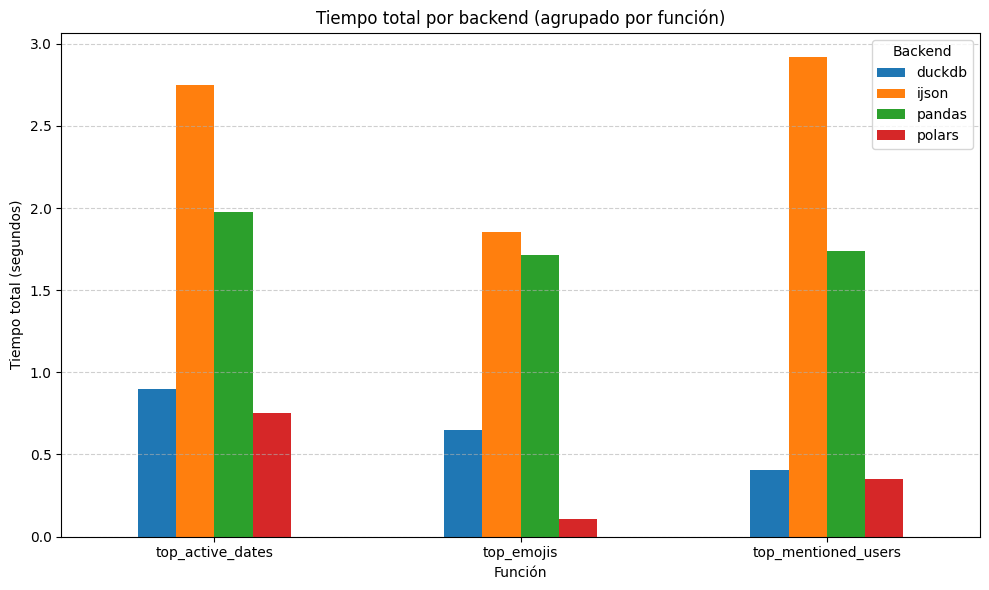

In [5]:
plt.figure(figsize=(10, 6))
pivot_tiempo_f.plot(kind="bar", ax=plt.gca())

plt.title("Tiempo total por backend (agrupado por función)")
plt.ylabel("Tiempo total (segundos)")
plt.xlabel("Función")
plt.legend(title="Backend")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

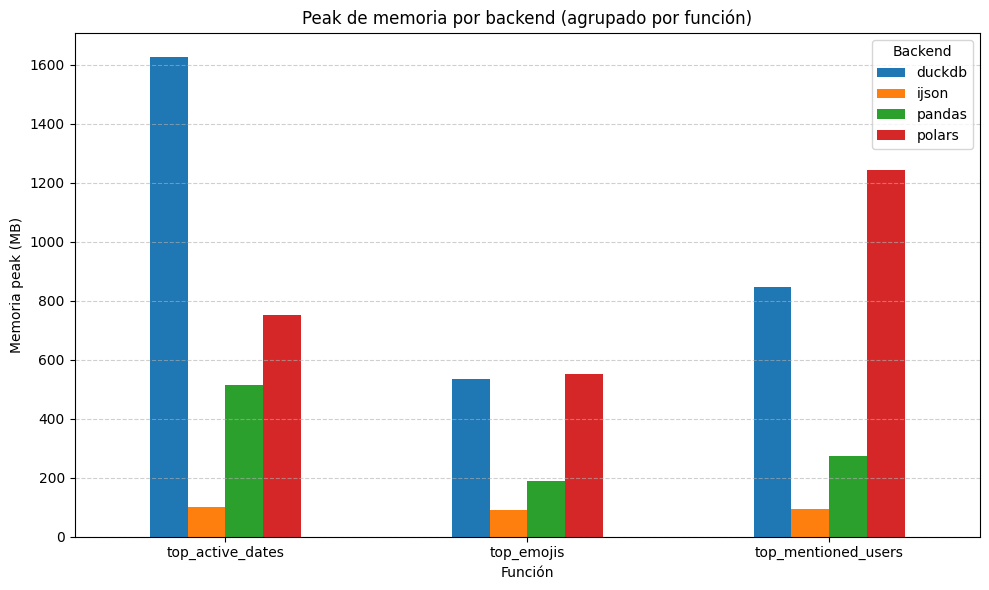

In [6]:
plt.figure(figsize=(10, 6))
pivot_mem_f.plot(kind="bar", ax=plt.gca())

plt.title("Peak de memoria por backend (agrupado por función)")
plt.ylabel("Memoria peak (MB)")
plt.xlabel("Función")
plt.legend(title="Backend")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusiones comparativas

A continuación se muestran las principales conclusiones extraídas de los resultados de benchmarking (tiempo total y pico de memoria) para cada función y cada backend:

| Función               | Backend | Tiempo (s) | Memoria pico (MB) |
|-----------------------|---------|------------|-------------------|
| **top_active_dates**  | pandas  | 1.977      | 515.30            |
|                       | polars  | 0.753      | 751.41            |
|                       | duckdb  | 0.898      | 1626.23           |
|                       | ijson   | 2.749      | 101.88            |
| **top_emojis**        | pandas  | 1.716      | 187.78            |
|                       | polars  | 0.109      | 549.78            |
|                       | duckdb  | 0.646      | 534.25            |
|                       | ijson   | 1.853      | 90.03             |
| **top_mentioned_users** | pandas  | 1.741      | 274.47            |
|                         | polars  | 0.354      | 1241.73           |
|                         | duckdb  | 0.403      | 847.69            |
|                         | ijson   | 2.920      | 94.48             |

#### 1. Rendimiento en tiempo
- **Polars** resultó ser el más rápido en las tres funciones:
  - `top_active_dates`: 0.753 s (frente a 0.898 s de DuckDB y 1.977 s de Pandas).  
  - `top_emojis`: 0.109 s (muy por debajo de los 0.646 s de DuckDB y 1.716 s de Pandas).  
  - `top_mentioned_users`: 0.354 s (aunque DuckDB quedó cerca con 0.403 s).  
- **DuckDB** quedó en segundo lugar, especialmente competitivo en `top_active_dates` y `top_mentioned_users`, pero supera a Polars en `top_emojis` únicamente en construcción y agrupación.  
- **Pandas** se posicionó como tercero en tiempo en todas las funciones, manteniéndose alrededor de 1.7 – 2.0 s.  
- **ijson** fue el más lento para cada función (2.75 s, 1.85 s, 2.92 s), reflejando la sobrecarga de procesamiento incremental y de contadores en Python puro.

#### 2. Consumo de memoria
- **ijson** mostró los peaks de memoria más bajos en todas las funciones:
  - `top_active_dates`: 101.88 MB  
  - `top_emojis`: 90.03 MB  
  - `top_mentioned_users`: 94.48 MB  
  Esto confirma que, a pesar de ser el más lento, ijson mantiene la huella de RAM considerablemente reducida.
- **Pandas** sorprendió con consumos intermedios relativamente bajos:
  - 515.30 MB en `top_active_dates`  
  - 187.78 MB en `top_emojis`  
  - 274.47 MB en `top_mentioned_users`  
  En particular, Pandas usó menos memoria que Polars en `top_active_dates` y menos que DuckDB en todas las funciones.
- **Polars** consumió más memoria que Pandas en `top_active_dates` (751.41 MB) y en `top_emojis` (549.78 MB), pero superó a DuckDB en `top_mentioned_users` (1241.73 MB frente a 847.69 MB de DuckDB).
- **DuckDB** presentó los peaks de memoria más altos para `top_active_dates` (1626.23 MB) y `top_mentioned_users` (847.69 MB), aunque en `top_emojis` su consumo (534.25 MB) fue ligeramente inferior al de Polars.

#### 3. Hipótesis inicial vs. resultados reales
- **Hipótesis de tiempo**: se esperaba que DuckDB, ejecutándose en `:memory:`, ofreciera el mejor rendimiento, pero en la práctica **Polars** resultó más rápido en todas las funciones, probablemente debido a su motor columnar optimizado en Rust y al paralelismo de Arrow.  
- **Hipótesis de memoria**: se anticipaba que ijson sería el líder en eficiencia de RAM, y los datos confirman que ijson mantiene **el peak de memoria más bajo**.

#### 4. Conclusión general
- Si el objetivo principal es **minimizar tiempo de ejecución**, **Polars** es la mejor opción para estas tareas de agregación y conteo sobre NDJSON.  
- Si el criterio más crítico es **consumo de memoria**, **ijson** es el más adecuado, sacrificando velocidad para mantener una huella de RAM muy pequeña.  
